# Clusterisation non supervisée d'images



## Introduction

L'objectif de ce notebook est d'étudier la classification automatique d'images issues de tweets liés au vote de la loi sur la PMA. L'objectif est de regrouper les images similaires. La stratégie est d'utilisé un réseau pré-entraîné afin d'extraire les caractéristiques de l'image et d'utiliser un algorithme d'évaluation de similitude afin de regrouper les images se ressemblant. Nous essayons d'extraires les caractéristiques à différents niveaux d'un modèle de convolution afi d'essayer de séparer de façon binaire l'ensemble d'images sur plusieurs niveaux en utilisant des caractéristiques de plus en plus abstraites.

**Note:** Le travail a été réalisé en collaboration avec 
Amassin Nacerddine qui a travaillé sur une clusterisation basée sur les k-means. Son notebook est diponible sur à l'adresse: https://colab.research.google.com/drive/1ryjeOkgZBzROFFljH9f2I_S84WBjO7JP

## Récupération des données

Nous commençons par récupérer les couches de convolution du modèle ResNet101V2 issu de la librairie Keras. Le modèle a été entraîné sur ImageNet.

In [ ]:
# Import des modules nécessaires

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet101V2

In [ ]:
conv_base = ResNet101V2(include_top=False,weights='imagenet',input_shape=(224,224,3))

171327488/171317808 [==============================] - 2s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

Le modèle est diviser en 5 groupes de convolutions. Nous commençons par séparé ces différents groupes en autant de modèle. Cela nous permettra d'avoir 5 niveaux d'extractions de features. L'arborescence de classification possèdera donc 5 niveaux, une clusterisation binaire étant effectuée à chaque niveau basée sur le score de similitude basée sur le cosinus. L'algorithme de classification permettra donc de créer au plus 32 (2 exposant 5) groupes, sachant que certains groupes seront peut-être vide.

In [ ]:
model_conv_1 = tf.keras.models.Model(
    [conv_base.inputs], [conv_base.layers[4].output]
)
model_conv_2 = tf.keras.models.Model([conv_base.layers[4].output], [conv_base.get_layer('conv2_block3_out').output])
model_conv_3 = tf.keras.models.Model([conv_base.get_layer('conv2_block3_out').output], [conv_base.get_layer('conv3_block4_out').output])
model_conv_4 = tf.keras.models.Model([conv_base.get_layer('conv3_block4_out').output],[conv_base.get_layer('conv4_block23_out').output])
model_conv_5 = tf.keras.models.Model([conv_base.get_layer('conv4_block23_out').output], [conv_base.get_layer('post_relu').output])
# On ajoute None pour permettre une comparaison des images avant le passage du CNN
models = [None, model_conv_1, model_conv_2, model_conv_3, model_conv_4, model_conv_5]


In [ ]:
!pip install -q kaggle

Les données d'image ont été stockées sur kaggle. Le code ci-dessous permet de se connecter à mon compte kaggle et de télécharger l'archive d'images. L'archive est extraite et un itérateur d'images est créer, qui homogéneise les tailles des images, et fait varier les pixels dans une plage de valeurs de 0 à 1.

In [ ]:
! mkdir ~/.kaggle 
! echo "{\"username\":\"mathiastiberghien\",\"key\":\"5fb1170d8a2034120c49eee2a484f955\"}" > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Téléchargement de l'archive
!kaggle datasets download -d mathiastiberghien/projet-nedra-pma

 99% 421M/424M [00:08<00:00, 55.2MB/s]
100% 424M/424M [00:08<00:00, 53.7MB/s]


In [ ]:
# Création des chemins d'extraction
import os

zip_path = '/content/flowers.zip'
extract_path = '/content/datasets/'
images_path = os.path.join(extract_path,'flowers')

In [ ]:
# Extraction de l'archive
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Prétraitement

In [ ]:
# Permet de mettre à l'echelle les valeurs des pixels
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 200
# La taille des images est adapté au modèle pré-entraîné
img_width = conv_base.input_shape[1]
img_height = conv_base.input_shape[2]

generator = datagen.flow_from_directory(extract_path, seed=2, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None)
#Le jeu de données est limité à un batch afin de limiter le temps de traitement
initial_batch = tf.data.Dataset.from_tensor_slices(generator[0]).batch(batch_size)

Found 603 images belonging to 1 classes.


L'affichage des images montre une grande disparité sémantique, avec quelques thèmes apparaissant comme, les manifestations, l'assemblée, la famille.

In [ ]:
# Affichage d'un lot d'images
import matplotlib.pyplot as plt

batch = generator[0]
columns = 10
rows = batch_size // columns
fig = plt.figure(figsize=(25, 3*rows))
for i in range(0, columns*rows):
    img = batch[i]
    sub_plot = fig.add_subplot(rows, columns, i+1)
    sub_plot.axis('off')
    sub_plot.set_title(i)
    plt.imshow(img)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Traitement

Reste à créer une méthode de séparation binaire d'un jeu d'image à partir d'un modèle. La méthode reçoit en paramètre une liste de groupes d'images, et un modèle. Une extraction de caractéristique est effectuée sur chaque groupe d'images par le modèle passé en paramètre le résultat de l'extraction est divisé en deux sous-groupes en se basant sur la fonction de similitude: Si la fonction retourne une valeur inférieure ou égale à zéro, l'image appartient au groupe de l'image de référence (la première image du groupe), sinon elle appartient à l'autre groupe.Le nombre de groupes est donc multiplié par deux à la suite de cette opération.

In [ ]:
flatten = tf.keras.layers.Flatten()

#Retourne True si le coefficient de similitude cosinus est inférieur à zéro, False sinon
def get_similarities(reference, features):
  # La fonction de perte cosine_similarity renvoit -1 quand les vecteurs ont un angle de 0° et 1 pour un angle de 180°
  # Une valeur inférieure à 0 indique donc que les images sont similaires et une valeur supérieure à 0 indique l'inverse
  cos_sim = tf.keras.losses.cosine_similarity(reference, features, axis=(1,2,3))
  # On calcule la moitié de la distance entre une ressemblance parfaite et la plus grosse dissemblance
  half_max_distance = ((tf.math.reduce_max(cos_sim)+1.)/2) - 1
  # Les valeurs de cosinus inférieur à la moitié de la distance maximale sont considérées comme semblables
  return cos_sim<half_max_distance

#Sépare un groupe de features en fonction de leur similarités
def split_group(group, indices, model:tf.keras.models.Model, batch_size=100):
  reference = None
  features = None
  #On limite a un seul dans le cadre des test pour réduire le temps de traitement
  num_batch = 1
  i = 1
  # les prédictions sont effectuées par lot pour permettre d'afficher l'écoulement du temps
  for batch in group:
    print("Predicting batch {}/{}".format(i, num_batch))
    if model is not None:
      f = model.predict(batch)
    else:
      f = batch
    if features is not None:
      features = tf.concat([features, f], 0)
    else:
      features = f
      print("features shape:{}".format(features.shape))
      reference = features[:1]
    i = i + 1
    if i>num_batch:
      break
  # Lorsque toutes les caractéristiques ont été extraite pour un modèle on cherche les similarités avec la première image du groupe
  similarities = get_similarities(reference, features)
  # Le groupe est divisé en deux, les images similaire à l'image de référence et les autres
  g_1 = tf.reshape(tf.where(similarities),[-1]).numpy()
  g_2 = tf.reshape(tf.where(tf.math.logical_not(similarities)),[-1]).numpy()
  result = []
  # Les groupes vides sont ignorés
  if len(g_1)>0:
    # Un nouveau dataset de features est extrait pour chaque groupe qui servira d'entrée au modèle du niveau suivant
    ds_1 = tf.data.Dataset.from_tensor_slices(tf.gather(features,g_1)).batch(batch_size)
    result = result + [(ds_1, tf.gather(indices,g_1))]
  if len(g_2)>0:
    ds_2 = tf.data.Dataset.from_tensor_slices(tf.gather(features,g_2)).batch(batch_size)
    result = result + [(ds_2,tf.gather(indices, g_2))]
  return result


Voic le code de traitement principal: on initialise un tableau de tuples (groupe, indices) qui représentent les ensembles de données à séparer, ainsi que les indices des images du dataset initial. Le but de l'algorithme est de séparer ces indices de façon binaire à chaque niveau du CNN. Le nombre de groupes double à chaque niveau à condition que chaque sous-groupe possède des images.

In [ ]:
groups_with_indices=[(initial_batch,np.arange(batch_size))]
i=0
for m in models:
  print("Level {}".format(i))
  new_groups_with_indices = []
  g = 1
  for (group, indices) in groups_with_indices:
    print("Group {}".format(g))
    result = split_group(group, indices, m, batch_size)
    new_groups_with_indices = new_groups_with_indices + result
    g = g + 1
  groups_with_indices = new_groups_with_indices
  print("Classified groups:{}".format(len(groups_with_indices)))
  i = i + 1
#groups_with_indices possède maintenant une collection de 32 groupes (certains peut-être vides, qui contiennent les features et indices de chaque image)
#Il reste à trier les images dans des dossiers pour pouvoir observer le résultat


Level 0
Group 1
Predicting batch 1/1
features shape:(200, 224, 224, 3)
Classified groups:2
Level 1
Group 1
Predicting batch 1/1
features shape:(24, 56, 56, 64)
Group 2
Predicting batch 1/1
features shape:(176, 56, 56, 64)
Classified groups:4
Level 2
Group 1
Predicting batch 1/1
features shape:(19, 28, 28, 256)
Group 2
Predicting batch 1/1
features shape:(5, 28, 28, 256)
Group 3
Predicting batch 1/1
features shape:(6, 28, 28, 256)
Group 4
Predicting batch 1/1
features shape:(170, 28, 28, 256)
Classified groups:8
Level 3
Group 1
Predicting batch 1/1
features shape:(1, 14, 14, 512)
Group 2
Predicting batch 1/1
features shape:(18, 14, 14, 512)
Group 3
Predicting batch 1/1
features shape:(1, 14, 14, 512)
Group 4
Predicting batch 1/1
features shape:(4, 14, 14, 512)
Group 5
Predicting batch 1/1
features shape:(1, 14, 14, 512)
Group 6
Predicting batch 1/1
features shape:(5, 14, 14, 512)
Group 7
Predicting batch 1/1
features shape:(1, 14, 14, 512)
Group 8
Predicting batch 1/1
features shape:(16

## Résultats

On peut voir lors du traitement ci-dessus l'évolution des caractéristiques à chaque niveau et la création de groupes. La variable `groups_with_indices` contient l'ensemble des sous-groupes du dernier niveau. On récupère maintenant les indices de chaques groupes pour retrouver les images considérées comme similaires. Nous commençons par afficher le nombre d'images associés à chaque groupe.

In [ ]:
folders = [i for f,i in groups_with_indices]

In [ ]:
index = 0
for i in folders:
  print("Folder {}: {} image(s)".format(index, len(i)))
  index = index + 1

Folder 0: 1 image(s)
Folder 1: 1 image(s)
Folder 2: 1 image(s)
Folder 3: 1 image(s)
Folder 4: 15 image(s)
Folder 5: 1 image(s)
Folder 6: 1 image(s)
Folder 7: 1 image(s)
Folder 8: 1 image(s)
Folder 9: 1 image(s)
Folder 10: 1 image(s)
Folder 11: 1 image(s)
Folder 12: 1 image(s)
Folder 13: 1 image(s)
Folder 14: 2 image(s)
Folder 15: 1 image(s)
Folder 16: 1 image(s)
Folder 17: 1 image(s)
Folder 18: 1 image(s)
Folder 19: 166 image(s)


Nous pouvons constater que la grande majorité des groupes ne possède qu'une seule image. Le dernier groupe ne contient pas forcément des images qui se ressemble: ils contient l'ensemble des images qui ne ressemblent pas à l'image du groupe précédent. La méthode ci-dessous permet d'afficher le contenu d'un dossier en utilisant les indices de l'images dans le dataset original.

In [ ]:
import math

def draw_folder(folder):
  columns = 8
  rows = math.ceil(len(folder)/columns)
  fig = plt.figure(figsize=(25, rows*3))
  index = 1
  for i in folder:
      img = batch[i]
      sub_plot = fig.add_subplot(rows, columns, index)
      index = index + 1
      sub_plot.axis('off')
      sub_plot.set_title(i.numpy())
      plt.imshow(img)
  plt.show()

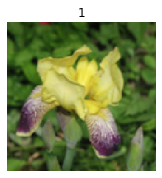

In [ ]:
draw_folder(folders[5])



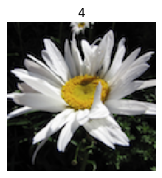

In [ ]:
draw_folder(folders[16])

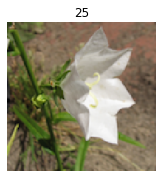

In [ ]:
draw_folder(folders[11])

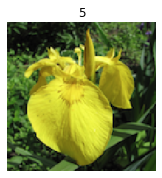

In [ ]:
draw_folder(folders[1])

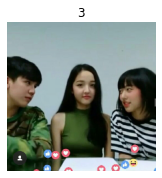

In [ ]:
draw_folder(folders[9])

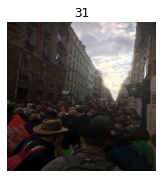

In [ ]:
draw_folder(folders[20])

Les regroupements sont assez décevants: On a l'impression que les tonalités sont les discriminants principaux. D'un point de vue sémantique, on est toujours dans la confusion. Il semble nécessaire de trouver des solutions pour affiner le classement.

## Analyse et perspectives



## *   La fonction de cosinus de similarité renvoit une valeur de -1 pour des vecteurs ayant le même angle et 1 pour des vecteurs diamétralement opposés: dans un premier temps, j'avais supposé que les valeurs inférieurs 0 seraient similaires et les valeurs supérieures ou égales à 0 seraient différentes. Pourtant, quel que soit le niveau d'abstraction, les images ont toujours eu des cosinus inférieurs à 0
*   En affichant les tableaux de similarités à chaque niveau d'abstraction, on réalise que le troisième niveau produit, pour les mêmes images originales, des cosinus de similarité bien meilleurs que les autres. A partir du quatrième niveau les cosinus se rapprochent de plus en plus de 0, probablement car le nombre de 0 augmente grandement au fur et à mesure qu'on s'enfonce dans le CNN.
*   Etablir une comparaison sur l'ensemble des channels semble une mauvais idée. Au fur et à mesure, les images sont de plus en plus petites alors que les channels sont de plus en plus nombreux. Il faut envisager d'obtenir des cosinus de similiarité pour chaque channels deux à deux et calculer le pourcentage de channels suffisament similaires. Cette comparaison devrait donner de meilleurs résultats
*   Il faut trouver comment gérer le dernier dossier: une solution serait de comparer récursivement la première image de ce groupe afin de créer de nouveaux sous-groupes qui contiennent des images qui se ressemblent.


